# Проект - компьютерный игры

В этом проекте мы анализируем данные отчетности о продажах интернет-магазина компьютерных игр "Стримчик".

В нашем распоряжении данные за несколько лет до 2016 года включительно, и задача подготовить эти данные для дальнейшего планирования продаж на 2017 год. Алгоритм подготовки данных должен поддерживать возможность переиспользования на данных за другие периоды при планировании последующих лет.

В процессе подготовки к исследованию мы проведем предобработку данных путем выполнения следующих работ:
- загрузка данных в формате CSV
- проверка и устранение явных дубликатов в записях
- проверка наличия пропусков в данных и их устранение
- приведем данные к правильным форматам
- добавим информацию об общем объеме продаж по всем регионам

Затем мы проведем исследовательский анализ данных, и выполним следующие действия:
- изучим данные о продажах за разные годы и по разным платформам
- выясним срок жизни игровых платформ
- определим Актуальный период для данных и очистим неактуальные данные
- изучим тенденции продаж по платформам
- исследуем корреляции продаж с отзывами игрроков и критиков

После этого, мы составим портрет потенциального покупателя в каждом из регионов:
- узнаем предпочтения по платформам
- поймем какие жанры популярны в разных регионах
- исследуем влияние рейтинга ESRB на продажи

В завершение исследования, мы проверим некоторые гипотезы методами математической статистики, и сформулируем итоговый вывод.

## Загрузка и подготовка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom

Загрузим данные в датафрейм pandas

In [2]:
data = pd.read_csv('/datasets/games.csv')
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Переименуем колонки

In [3]:
data = data.rename(columns=
            {'Name': 'name',
             'Platform': 'platform',
             'Year_of_Release': 'year',
             'Genre': 'genre',
             'NA_sales': 'na_sales',
             'EU_sales': 'eu_sales',
             'JP_sales': 'jp_sales',
             'Other_sales': 'other_sales',
             'Critic_Score': 'critic_score',
             'User_Score': 'user_score',
             'Rating': 'rating'})

Изучим информацию о данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16713 non-null  object 
 1   platform      16715 non-null  object 
 2   year          16446 non-null  float64
 3   genre         16713 non-null  object 
 4   na_sales      16715 non-null  float64
 5   eu_sales      16715 non-null  float64
 6   jp_sales      16715 non-null  float64
 7   other_sales   16715 non-null  float64
 8   critic_score  8137 non-null   float64
 9   user_score    10014 non-null  object 
 10  rating        9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Проверим наличие явных дубликатов

In [5]:
data.duplicated().sum()

0

Проверим наличие неявных дубликатов - дублированных записей о продажах игр с одним наименованием в одном и том же году на одинаковых платформах:

In [6]:
temp = data[['name', 'platform', 'year']]
temp.duplicated().sum()

2

In [7]:
temp[temp.duplicated() == True]

,name,platform,year
14244,NaN,GEN,1993.0
16230,Madden NFL 13,PS3,2012.0


In [8]:
data.query('(name == "Madden NFL 13") & (platform == "PS3")')

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012.0,Sports,2.11,0.22,0.0,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012.0,Sports,0.00,0.01,0.0,0.00,83.0,5.5,E


Мы нашли две дублированные записи о продажах - одна для игры без имени за очень старый год, другая для корректной записи игры, но с незначительным набором данных. Оставим эти данные в наборе, поскольку первая содержит пропуск и будет обработана на следующем шаге, а вторая не повлияет на результаты анализа, поскольку все остальные данные в этой строке корректные, а данные о продажах ничтожно малы.

Проверим наличие пропусков

In [9]:
data.isna().sum()

name               2
platform           0
year             269
genre              2
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    8578
user_score      6701
rating          6766
dtype: int64

Заполним обнаруженные пропуски

In [10]:
data = data.dropna(subset=['name']).reset_index(drop=True)
data = data.dropna(subset=['year']).reset_index(drop=True)
data['genre'] = data['genre'].fillna('Unknown')
data['critic_score'] = data['critic_score'].fillna(-1)
data['user_score'] = data['user_score'].fillna(-1)
data['rating'] = data['rating'].fillna('Unknown')

Проверим результат

In [11]:
data.isna().sum()

name            0
platform        0
year            0
genre           0
na_sales        0
eu_sales        0
jp_sales        0
other_sales     0
critic_score    0
user_score      0
rating          0
dtype: int64

Заменим на нулевые значения 'tbd' в поле оценки пользователей

In [12]:
for row in data.index:
    if data.loc[row, 'user_score'] == 'tbd':
        data.loc[row, 'user_score'] = -1

Приведем данные к правильному формату

In [13]:
data['year'] = data['year'].astype('int32')
data['critic_score'] = data['critic_score'].astype('int32')
data['user_score'] = data['user_score'].astype('float32')

Вычислим суммарные продажи и поместим в отдельный столбец

In [14]:
#data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data['total_sales'] = data.loc[:, ['na_sales','eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

**Вывод по этапу предобработки данных**

Данные в хорошем состоянии, без явных дубликатов, наличием неявных дубликатов можно пренебречь.

Обнаружены пропуски, которые мы устранили следующим образом:
- два пропуска в поле name (название игры) удалили в силу их немногочисленности
- пропуски в следующих полях заменили на значение по-умолчанию, поскольку эти данные являются качественными характеристиками, и присвоение им какого-либо из имеющихся значений исказит отчетность:
 - genre (жанр)
 - rating (рейтинг ESRB)
- пропуски в поле year (год продаж) - убрали эти данные из анализа, поскольку информация о годе продаж является ключевой для анализа, и ее отсутствие делает эти записи бесполезными
- пропуски в оценках критиков и игроков заменили на нулевые значения, поскольку эти пропуски означают отсутствие оценки, а пропуск будет мешать дальнейшей работе с этими данными

Предполагаемые причины возникновения этих пропусков:
- пропуски в полях name, genre и year скорее всего носят технический характер
- пропуски в поле rating (рейтинг ESRB) обусловлены тем, что этот рейтинг существует только для США и Канады
- пропуски в оценках критиков и игроков скорее всего означают отсутствие оценки

В поле пользовательских оценок также были обнаружены одинаковые значение "tbd", которые очевидно носят некий технический характер. Поскольку эти значения по уровню информативности для дальнейшего анализа идентичны пропускам, мы также заменили их на нулевые значения.

Также мы привели данные к правильным форматам:
- поле year из строки в целое число, для обеспечения возможности вычислений периодов по этим данным 
- поле critic_score из вещественного в целое число, поскольку этот рейтинг вычисляется путем сложения целых оценок по критериям, и в итого не имеет знаков после запятой
- поле user_score из строки в вещественное число, для обеспечения возможности количественного анализа, и в соответствии с принципом формирования этого значения, как среднее значение набора целых числовых оценок. 

In [15]:
# Комментарий ревьюера
# Посмотрим, что осталось
temp = data.copy() 
list_c = ['name', 'platform', 'year', 'genre', 'critic_score', 'user_score', 'rating']
print(temp.info())
for col_l in list_c:
  print('-'* 25)
  print(col_l, temp[col_l].sort_values().unique())
  print(col_l,' : кол-во 0', temp[temp[col_l] == 0][col_l].count(),
        ', процент 0', round(temp[temp[col_l] == 0][col_l].count()/len(temp)*100, 2),'%')
  print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().mean()*100,2),'%') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16444 non-null  object 
 1   platform      16444 non-null  object 
 2   year          16444 non-null  int32  
 3   genre         16444 non-null  object 
 4   na_sales      16444 non-null  float64
 5   eu_sales      16444 non-null  float64
 6   jp_sales      16444 non-null  float64
 7   other_sales   16444 non-null  float64
 8   critic_score  16444 non-null  int32  
 9   user_score    16444 non-null  float32
 10  rating        16444 non-null  object 
 11  total_sales   16444 non-null  float64
dtypes: float32(1), float64(5), int32(2), object(4)
memory usage: 1.3+ MB
None
-------------------------
name [' Beyblade Burst' ' Fire Emblem Fates' " Frozen: Olaf's Quest" ...
 'uDraw Studio' 'uDraw Studio: Instant Artist'
 '¡Shin Chan Flipa en colores!']
name  : кол-во 0 0 , процент 0 

## Исследовательский анализ данных

Построим график по сводной таблице, в которой посчитаем количество игр по годам.

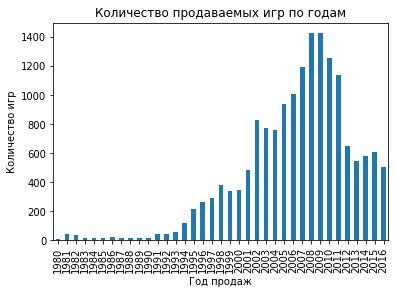

In [16]:
data.pivot_table(index='year', values='name', aggfunc='count').plot(kind='bar', legend=False)
plt.title('Количество продаваемых игр по годам')
plt.xlabel('Год продаж')
plt.ylabel('Количество игр')
plt.show()

**Вывод**
В разные периоды на платформе "Стримчик" продавалось разное количество игр. В период с 1980 до 1990 года выпускалось очень мало игр, очевидно в силу того, что игровая индустрия в этот период находилась на начальном уровне развития. В 90-х годах прошлого века наблюдался период развития этой отрасли, а бум продаж приходится на период с 2002 до 2012 года, с пиком в 2008-2009 годах, после чего продажи по всем платформам начали стремительно падать.

**Изучим динамику продаж по платформам**

Выберем платформы с наибольшими суммарными продажами:

In [17]:
sales_by_platform = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
mean_sales = sales_by_platform['total_sales'].mean()
top_sellers = sales_by_platform.query('total_sales >= @mean_sales')
top_sellers.index

Index(['DS', 'GBA', 'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'Wii', 'X360'], dtype='object', name='platform')

Построим распределение продаж по годам среди ведущих игровых платформ:

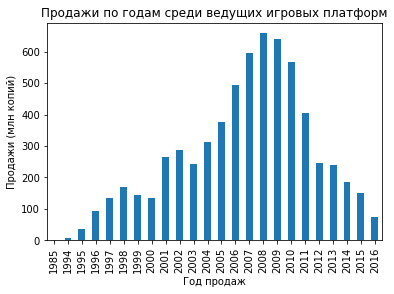

In [18]:
top_sales = data.query('platform in @top_sellers.index')
top_sales.pivot_table(index='year', values='total_sales', aggfunc='sum').plot(kind='bar', legend=False)
plt.title('Продажи по годам среди ведущих игровых платформ')
plt.xlabel('Год продаж')
plt.ylabel('Продажи (млн копий)')
plt.show()

Рассчитаем типичный срок жизни игровых платформ

In [19]:
platform_life = data.pivot_table(index='platform', values='year', aggfunc=['min', 'max'])
platform_life.columns = ['start', 'end']
platform_life['age'] = platform_life['end'] - platform_life['start'] + 1
typical_age = int(platform_life['age'].median())
print(f'Характерный срок жизни платформы: {typical_age} лет')

Характерный срок жизни платформы: 7 лет


In [20]:
# Комментарий ревьюера
temp = data.copy() 
time_life = temp.pivot_table(index='platform', values='year', aggfunc=['min', 'max']).reset_index()
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()

7.0

**Вывод 2**

Лидерами продаж являются игры для игровых приставок, такие как Play Station и XBox.

Платформы обновляются в среднем каждые 7 лет.

Установим Актуальный период как 3 года и уберем данные за прошлые периоды

In [21]:
actual_period = 3
planned_year = 2017
data = data[data['year'] >= (planned_year - actual_period)].reset_index(drop=True)

Изучим общий объем продаж по платформам

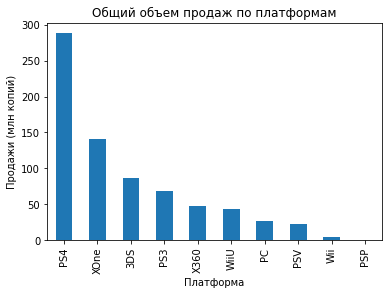

In [23]:
sales = data[['platform', 'year', 'total_sales', 'user_score', 'critic_score', 'genre']]
platform_sales = data.pivot_table(index='platform', values='total_sales', aggfunc='sum')
platform_sales.sort_values(by='total_sales', ascending=False).plot(kind='bar', legend=False)
plt.title('Общий объем продаж по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн копий)')
plt.show()

Выявим лидеров по продажам - платформы с продажами выше медианы по всей выборке

In [24]:
median_sales = platform_sales['total_sales'].median()
top_sales = platform_sales.query('total_sales > @median_sales').sort_values(by='total_sales', ascending=False)

Исследуем динамику продаж

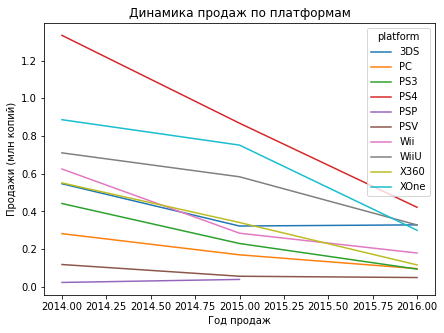

In [25]:
sales_trend = data.pivot_table(index='year', columns='platform', values='total_sales')
sales_trend.plot(figsize=(7,5))
plt.title('Динамика продаж по платформам')
plt.xlabel('Год продаж')
plt.ylabel('Продажи (млн копий)')
plt.show()

Выберем топ-3 платформы по продажам в 2016 году:

In [26]:
data.query('year == 2016').pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head(3)

,total_sales
platform,
PS4,69.25
XOne,26.15
3DS,15.14


**Вывод**

Динамика продаж почти по всем платформам демонстрирует тенденцию к падению. Незначительный рост показывает только платформа 3DS. 

Потенциально прибыльными платформами можно считать следующие:
- PS4
- XOne
- 3DS

Построим диаграммы размаха по глобальным продажам игр в разбивке по платформам.

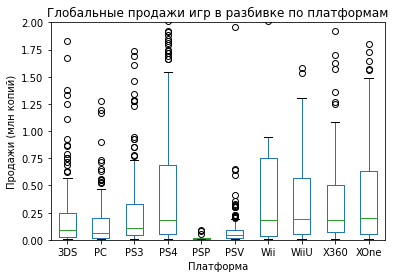

In [28]:
data.pivot_table(index='name', columns='platform', values='total_sales').plot(kind='box', ylim=(0, 2))
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн копий)')
plt.show()

**Вывод**

На диаграммах размаха мы видим большое количество выбросов почти по всем платформам. Очевидно, эти выбросы означают "дойных коров" этих платформ - небольшое количество игр, которые приносят большую часть выручки. 

**Изучим как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков**

Изучим корреляцию между отзывами игроков и продажами на платформе PS4 на диаграмме рассеяния

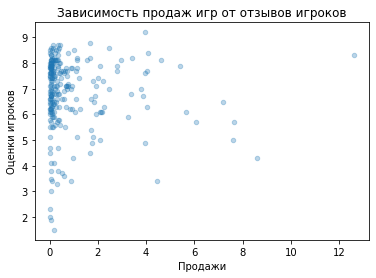

In [29]:
check_platform = 'PS4'
tmp_data = data.query('(platform == @check_platform) & (user_score != -1)')
tmp_data.plot(x='total_sales', y='user_score', kind='scatter', alpha=0.3)
plt.title('Зависимость продаж игр от отзывов игроков')
plt.xlabel('Продажи')
plt.ylabel('Оценки игроков')
plt.show()

Изучим корреляцию между оценками критиков и продажами на платформе PS4 на диаграмме рассеяния

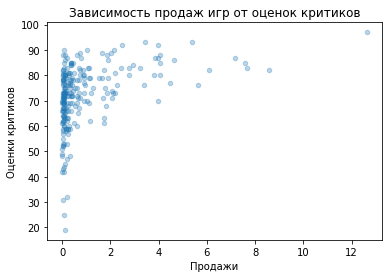

In [30]:
tmp_data2 = data.query('(platform == @check_platform) & (critic_score != -1)')
tmp_data2.plot(x='total_sales', y='critic_score', kind='scatter', alpha=0.3)
plt.title('Зависимость продаж игр от оценок критиков')
plt.xlabel('Продажи')
plt.ylabel('Оценки критиков')
plt.show()

Рассчитаем числовые значения этих корреляций:

In [31]:
usr_corr = round(tmp_data['total_sales'].corr(tmp_data['user_score']), 2)
crt_corr = round(tmp_data2['total_sales'].corr(tmp_data2['critic_score']), 2)
print(f'Коэффициент корреляции продаж с отзывами игроков равен {usr_corr}')
print(f'Коэффициент корреляции продаж с оценками критиков равен {crt_corr}')

Коэффициент корреляции продаж с отзывами игроков равен -0.04
Коэффициент корреляции продаж с оценками критиков равен 0.4


**Вывод**
Объем продаж игр на платформе PS4 практически совсем не сильно зависит от отзывов пользователей - это видно и на графике, и по числовому значению коэффициента корреляции. В то же время, зависимость продаж от оценок критиков существенно сильнее, что подтверждается числовым значением коэффициента.

Получается, существенная часть пользователей ориентируются на отзывы критиков при покупке игр.

Подберем еще три лидирующие платформы для подтверждения результатов анализа: 

In [32]:
top_platforms = data.query('year == 2016').pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False).head(4)

Построим аналогичные диаграммы и рассчитаем значения корреляции для этих платформ

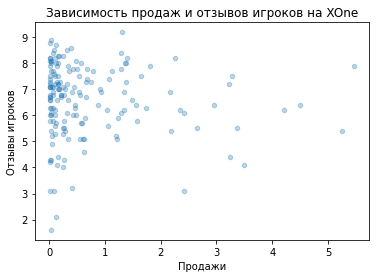

Коэффициент корреляции: -0.07


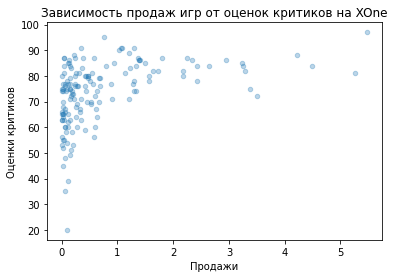

Коэффициент корреляции: 0.43


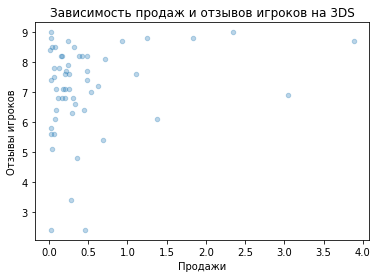

Коэффициент корреляции: 0.22


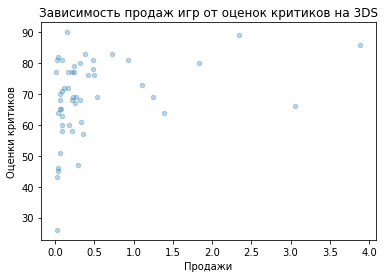

Коэффициент корреляции: 0.31


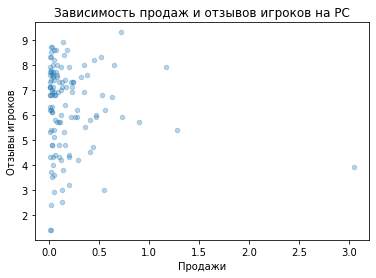

Коэффициент корреляции: -0.07


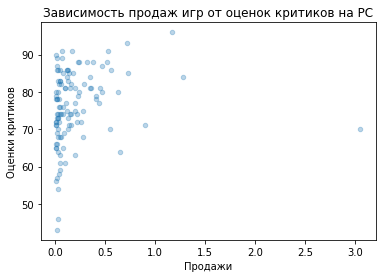

Коэффициент корреляции: 0.17


In [33]:
for check_platform in top_platforms.index[1:]:
    #диаграмма по отзывам игроков
    tmp_data = data.query('(platform == @check_platform) & (user_score != -1)')
    tmp_data.plot(x='total_sales', y='user_score', kind='scatter', alpha=0.3)
    plt.title(f'Зависимость продаж и отзывов игроков на {check_platform}')
    plt.xlabel('Продажи')
    plt.ylabel('Отзывы игроков')
    plt.show()
    #коэффициент корреляции по отзывам игроков
    usr_corr = round(tmp_data['total_sales'].corr(tmp_data['user_score']), 2)
    print(f'Коэффициент корреляции: {usr_corr}')
    #диаграмма по оценкам критиков
    tmp_data2 = data.query('(platform == @check_platform) & (critic_score != -1)')
    tmp_data2.plot(x='total_sales', y='critic_score', kind='scatter', alpha=0.3)
    plt.title(f'Зависимость продаж игр от оценок критиков на {check_platform}')
    plt.xlabel('Продажи')
    plt.ylabel('Оценки критиков')
    plt.show()
    #коэффициент корреляции по оценкам критиков
    crt_corr = round(tmp_data2['total_sales'].corr(tmp_data2['critic_score']), 2)
    print(f'Коэффициент корреляции: {crt_corr}')

**Вывод**

Для платформы XOne мы можем наблюдать полностью аналогичную ситуацию. В то же время, пользователи платформы 3DS гораздо больше ориентируются на отзывы других игроков, хотя оценки критиков имеют для них все же большее значение. А игроки на PC почти не смотрят ни на то ни на другое - очевидно для этой платформы большее значение имеет маркетинг.

**Изучим распределение игр по жанрам**

Построим распределение суммарных продаж игр по жанрам:

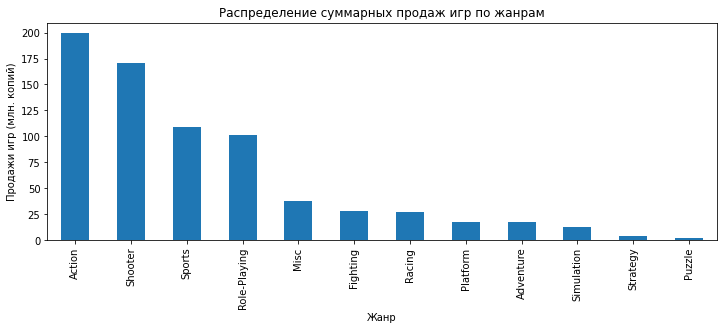

In [34]:
genre_sales = data.pivot_table(index='genre', values='total_sales', aggfunc="sum")
genre_sales = genre_sales.sort_values(by='total_sales', ascending=False)
genre_sales.plot(kind='bar', figsize=(12,4), legend=False)
plt.title('Распределение суммарных продаж игр по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи игр (млн. копий)')
plt.show()

Как видно на графике, лидерами суммарных продаж являются игры в жанрах Action и Shooter, следом идут игры в жанрах Sports и Role-Playing. Игры в жанре Puzzle пользуются минимальным спросом. Самыми высокие продажи по всей выборке имеет жанр Action.

Проанализируем распределение медианных продаж игр по жанрам.

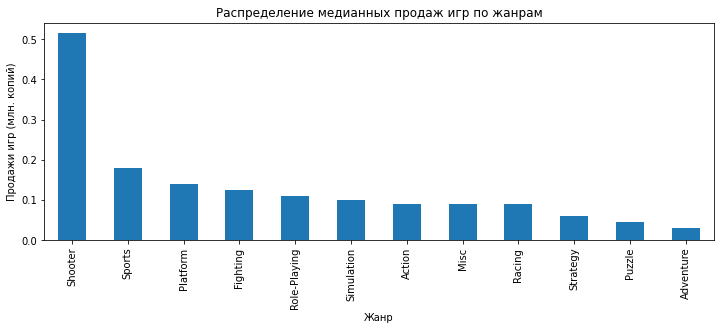

In [35]:
genre_sales = data.pivot_table(index='genre', values='total_sales', aggfunc="median")
genre_sales = genre_sales.sort_values(by='total_sales', ascending=False)
genre_sales.plot(kind='bar', figsize=(12,4), legend=False)
plt.title('Распределение медианных продаж игр по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи игр (млн. копий)')
plt.show()

На этом распределении мы видим кардинально иную ситуацию - наибольшие медианные продажи с большим отрывом демонстрирует жанр Shooter, а из остальных лидирует жанр Sports.

Проанализируем эти данные на диаграммах размаха: 

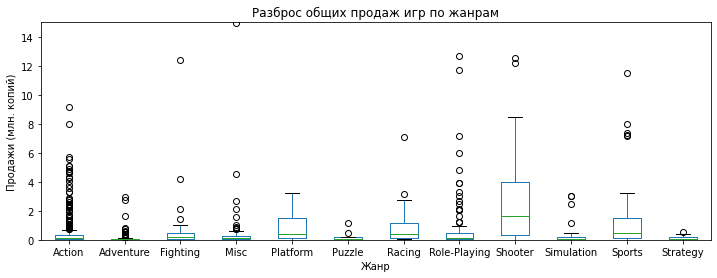

In [36]:
data.pivot_table(index='name', columns='genre', values='total_sales', aggfunc="sum").plot(kind='box',figsize=(12,4), ylim=(0,15))
plt.title('Разброс общих продаж игр по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи (млн. копий)')
plt.show()

На диаграммах размаха мы можем наблюдать, что основной объем продаж игр в таких жанрах, как Action и RPG, создают отдельные удачные проекты, в то время как игры в таких жанрах как Shooter, Platform, Sports и Racing, хорошо продаются в основной своей массе.

**Вывод**

Из проведенных исследований можно сделать вывод о том, что хотя игры в жанрах Action и Shooter демонстрируют наибольшие общие продажи, будут стабильно более прибыльными будут игры в жанрах Shooter, Platform, Sports и Racing, в том числе новые, в силу популярности этих жанров и независимости от качества отдельных проектов или поддерживаемых платформ.

**Общий вывод по этапу исследовательского анализа данных**

В разные периоды на платформе "Стримчик" продавалось разное количество игр. В период с 1980 до 1990 года выпускалось очень мало игр, очевидно в силу того, что игровая индустрия в этот период находилась на начальном уровне развития. В 90-х годах прошлого века наблюдался период развития этой отрасли, а бум продаж приходится на период с 2002 до 2012 года, с пиком в 2008-2009 годах, после чего продажи по всем платформам начали стремительно падать.

Лидерами продаж являются игры для игровых приставок, такие как Play Station и XBox.

Платформы обновляются в среднем каждые 7 лет.

Значение Актуального периода решено установить как 3 года, для того чтобы оценить, на каком этапе жизненного цикла находится та или иная платформа, для прогнозирования продаж.

Динамика продаж почти по всем платформам демонстрирует тенденцию к падению. Эту информацию следует дополнительно  проанализировать на предмет того, является ли это признаком глобального заката мировой игровой индустрии или проблемами интернет-магазина "Стримчик".

Потенциально прибыльными платформами в 2017 году могут стать PS4, XOne и 3DS.

На диаграммах размаха мы видим большое количество выбросов почти по всем платформам. Очевидно, эти выбросы означают "дойных коров" этих платформ - небольшое количество игр, которые приносят большую часть выручки.

Продажи игр в существенно большей степени зависят от оценок критиков, чем от отзывов отзывов пользователей, на платформах PS4 и XOne - очевидно в силу схожести их бизнес-модели. В то же время, пользователи платформы 3DS гораздо больше ориентируются на отзывы других игроков, хотя оценки критиков имеют для них все же большее значение. А игроки на PC почти не смотрят ни на то ни на другое - очевидно для этой платформы большее значение имеет маркетинг.

Лидерами суммарных продаж являются игры в жанрах Action и Shooter, однако стабильно более прибыльными будут игры в жанрах Shooter, Platform, Sports и Racing, в том числе новые, в силу популярности этих жанров и независимости от качества отдельных проектов или поддерживаемых платформ.

## Портрет пользователя по регионам

Построим сводную таблицу продаж в регионах по платформам и отобразим результаты в виде круговых диаграмм:

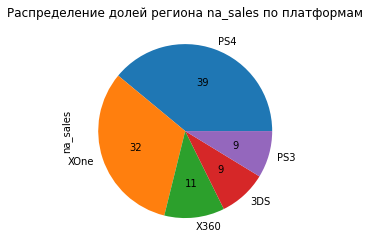

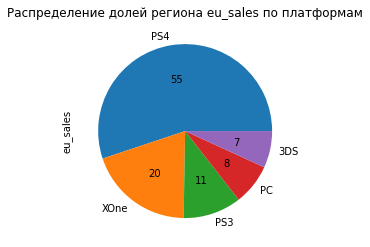

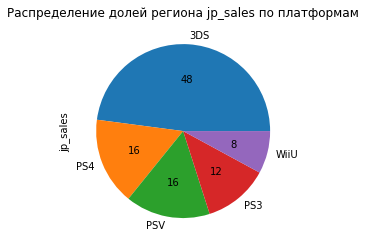

In [37]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
for region in regions:
    region_sales = data.pivot_table(index='platform', values=region, aggfunc='sum')
    region_sales.sort_values(by=region, ascending=False).head(5).plot(kind='pie', autopct='%.0f', subplots=True, legend=False)
    plt.title(f'Распределение долей региона {region} по платформам')
    plt.show()

**Вывод**

В Северной Америке и Европе наибольшую популярность имеют платформа PS4, на втором месте платформа XOne. В то же время, в Японии лидирует платформа 3DS, а платформа XOne вообще не представлена.

Построим сводные таблицы продаж в регионах по жанрам и отобразим результаты в виде круговых диаграмм:

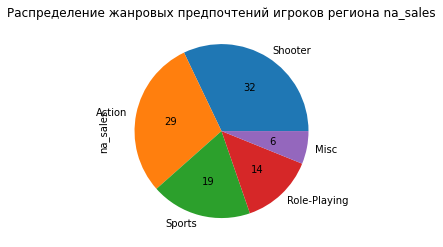

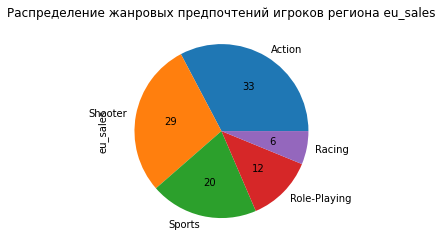

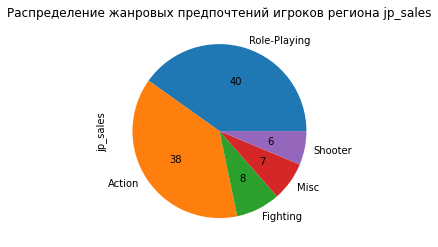

In [38]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
for region in regions:
    region_sales = data.pivot_table(index='genre', values=region, aggfunc='sum')
    region_sales.sort_values(by=region, ascending=False).head(5).plot(kind='pie', normalize=True, autopct='%.0f', subplots=True, legend=False)
    plt.title(f'Распределение жанровых предпочтений игроков региона {region}')
    plt.show()

**Вывод**

Жанровые предпочтения пользователей Северной Америки и Европы схожи, очевидно в силу культурного сходства населения этих регионов - явное преимущество имеют игры в жанрах Action и Shooter. Пользователи из Японии, напротив, отдают наибольшее предпочтение ролевым играм, хотя жанр Action тоже пользуется существенной популярностью, а игры в жанре Shooter находятся только на четвертом месте по рейтингу.

**Задача 3**

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

Построим графики продаж игр в зависимости от рейтинга ESRB по регионам

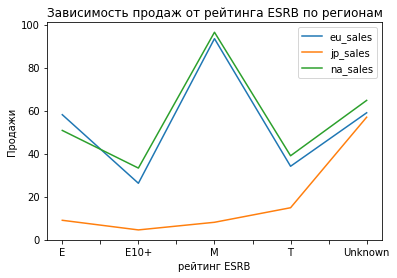

In [39]:

check_platform = 'XOne'
data.pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum').plot()
plt.title('Зависимость продаж от рейтинга ESRB по регионам')
plt.xlabel('рейтинг ESRB')
plt.ylabel('Продажи')
plt.show()

**Описание портретов пользователей в регионах**

Потребительское поведение пользователей в регионах демонстрирует предпочтение к национальным платформам, в частности XBox для Северной Америки и 3DS от Nintendo для Японии. В Европе нет крупных производителей игровых платформ, поэтому в этом регионе продажи распределены пропорционально маркетинговым усилиям японских и американских корпораций.

Жанровые предпочтения пользователей Северной Америки и Европы схожи, очевидно в силу культурного сходства населения этих регионов - явное преимущество имеют игры в жанрах Action и Shooter. Пользователи из Японии, напротив, отдают наибольшее предпочтение ролевым играм, а игры в жанре Shooter находятся только на четвертом месте по рейтингу.

Влияние рейтинга ESRB также более ярко выражено в Северной Америке и Европе, особенно у игр для взрослых. Поскольку рейтинг ESRB актуален только для США и Канады, а пользователи в Японии тяготеют к национальным игровым платформам, влияние этого рейтинга в этом регионе минимально.  

## Проверка гипотез

**Гипотеза 1**

Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Сначала рассчитаем средние пользовательские рейтинги по анализируемым платформам в имеющемся наборе данных:

In [40]:
XOne_score = data.query('(platform == "XOne") & (user_score != -1)')['user_score']
PC_score = data.query('(platform == "PC") & (user_score != -1)')['user_score']
print('Средний пользовательский рейтинг игр на платформе Xbox One:', np.ceil(np.mean(XOne_score)))
print('Средний пользовательский рейтинг игр на платформе PC:', np.ceil(np.mean(PC_score)))

Средний пользовательский рейтинг игр на платформе Xbox One: 7.0
Средний пользовательский рейтинг игр на платформе PC: 7.0


Как мы можем видеть, средние рейтинги пользовательские рейтинги платформ Xbox One и PC в имеющемся датасете равны.

In [41]:
# Комментарий ревьюера
XOne_score.min(), PC_score.min()

(1.6, 1.4)

Теперь проверим эту гипотезу средствами математической статистики:
Сформулируем статистические гипотезы:
H0 = Средние пользовательские рейтинги платформ Xbox One и PC равны друг другу
HA = Средние пользовательские рейтинги платформ Xbox One и PC различны

Проверим нулевую гипотезу (H0) при помощи двустороннего T-теста, установив минимальный общепринятый порог значимости (5%)

In [42]:
alpha = 0.05
 
result = st.ttest_ind(XOne_score, PC_score, alternative='two-sided')
if result.pvalue < alpha:
    print('p-value =', result.pvalue)
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('p-value =', result.pvalue)
    print('Нулевая гипотеза не отвергается')

p-value = 0.10450648833224654
Нулевая гипотеза не отвергается


По результатам Т-теста нам не удалось опровергнуть нулевую гипотезу о том, что средние пользовательские рейтинги платформ Xbox One и PC равны друг другу.

**Гипотеза 2**

Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Сначала рассчитаем средние пользовательские рейтинги игр в жанрах Action и Sports в имеющемся наборе данных:

In [43]:
action_score = data.query('(genre == "Action") & (user_score != -1)')['user_score']
sports_score = data.query('(genre == "Sports") & (user_score != -1)')['user_score']
print('Средний пользовательский рейтинг игр в жанре Action:', np.ceil(np.mean(action_score)))
print('Средний пользовательский рейтинг игр в жанре Sports:', np.ceil(np.mean(sports_score)))

Средний пользовательский рейтинг игр в жанре Action: 7.0
Средний пользовательский рейтинг игр в жанре Sports: 6.0


Как мы можем видеть, в имеющемся наборе данных средние пользовательские рейтинги игр в жанрах Action и Sports отличаются.

Теперь проверим эту гипотезу средствами математической статистики.
Сформулируем статистические гипотезы:

H0 = Средние пользовательские рейтинги игр в жанрах Action и Sports равны
HA = Средние пользовательские рейтинги игр в жанрах Action и Sports различны

Проверим нулевую гипотезу (H0) при помощи двустороннего T-теста, установив минимальный общепринятый порог значимости (5%)

In [44]:
alpha = 0.05

result = st.ttest_ind(action_score, sports_score, alternative='two-sided')
if result.pvalue < alpha:
    print('p-value =', result.pvalue)
    print('Отвергаем нулевую гипотезу в пользу альтернативной')
else:
    print('p-value =', result.pvalue)
    print('Нулевая гипотеза не отвергается')

p-value = 2.871146400695882e-19
Отвергаем нулевую гипотезу в пользу альтернативной


По результатам Т-теста следует отвергнуть нулевую гипотезу о том, что средние пользовательские рейтинги игр в жанрах Action и Sports равны друг другу.

**Результаты проверки гипотез**

Для проверки первой гипотезы о равенстве рейтингов платформ Xbox One и PC мы использовали двусторонний Т-тест, поскольку нам неважно было понимать, рейтинг какой платформы выше, а только оценить вероятность их отличия.

Нулевая гипотеза для этого теста была сформулирована как "Средние рейтинги платформ равны", а Альтернативная гипотеза - "Средние рейтинги платформ отличаются".

Несмотря на то, что по данным выборки средние рейтинги оцениваемых платформ явным образом отличались, результаты проведенного Т-теста показали, что рейтинги платформ Xbox One и PC на другой выборке с вероятностью порядка 25% будут равны. 

***Таким образом, Гипотеза 1 оказалась верной.***

Для проверки второй гипотезы о различии пользовательских рейтингов игр в жанрах Action и Sports мы также использовали двусторонний Т-тест, по той же причине - для проверки неважно понимать рейтинг какого жанра может оказаться выше.

Нулевая гипотеза для этого теста была сформулирована как "Средние рейтинги по жанрам равны", а Альтернативная гипотеза - "Средние рейтинги по жанрам отличаются".

Результаты проведенного Т-теста показали, что рейтинги игр в жанрах Action и Sports на другой выборке с крайне низкой вероятностью будут равны, в связи с чем нам следует отвергнуть нулевую гипотезу о равенстве рейтингов, и принять альтернытивную гипотезу о том, что средние пользовательские рейтинги игр в жанрах Action и Sports различны.

***Таким образом, Гипотеза 2 также оказалась верной.***

## Общий вывод

По результатам анализа данных отчетности о продажах интернет-магазина компьютерных игр "Стримчик" можно сообщить следующее:

**Состояние данных**

* Данные в хорошем состоянии, явные дубликаты не обнаружены, неявные дубликаты в ничтожном количестве.
* Выявлено небольшое количество пропусков, которые были устранены без ущерба для пригодности данных к анализу
* Имелись несколько фактов некорректного форматирования даных

**Результаты исследовательского анализа данных**

* В период с 1980 до 1990 года выпускалось очень мало игр
* В 90-х годах прошлого века наблюдался период развития этой индустрии компьютерных игр
* Бум продаж приходится на период с 2002 до 2012 года, с пиком в 2008-2009 годах
* После 2009 года продажи по всем платформам начали стремительно падать.

Лидерами продаж являются игры для игровых приставок, такие как Play Station и XBox.

Динамика продаж почти по всем платформам демонстрирует тенденцию к падению. Незначительный рост показывает только платформа 3DS. Потенциально прибыльными платформами можно считать следующие:
- PS4
- XOne
- 3DS

На диаграммах размаха мы видим большое количество выбросов почти по всем платформам. Очевидно, эти выбросы означают "дойных коров" этих платформ - небольшое количество игр, которые приносят большую часть выручки.

Объем продаж игр практически не зависит от отзывов пользователей на всех платформах, кроме 3DS. При этом, зависимость продаж от оценок критиков существенно сильнее. Получается, существенная часть пользователей ориентируются на отзывы критиков при покупке игр.

Из проведенных исследований можно сделать вывод о том, что хотя игры в жанрах Action и Shooter демонстрируют наибольшие общие продажи, будут стабильно более прибыльными будут игры в жанрах Shooter, Platform, Sports и Racing, в том числе новые, в силу популярности этих жанров и независимости от качества отдельных проектов или поддерживаемых платформ.

**Очистка данных**

* Характерный срок жизни игровых платформ составляет 7 лет.
* Для целей анализа принято решение установить Актуальный период как 3 года
* Данные по продажам за пределами Актуального периода были исключены из анализа

**Портреты пользователей по регионам**

Потребительское поведение пользователей в регионах демонстрирует предпочтение к национальным платформам, в частности XBox для Северной Америки и 3DS от Nintendo для Японии. В Европе нет крупных производителей игровых платформ, поэтому в этом регионе продажи распределены пропорционально маркетинговым усилиям японских и американских корпораций.

В Северной Америке и Европе наибольшую популярность имеют платформа PS4, на втором месте платформа XOne. В то же время, в Японии лидирует платформа 3DS, а платформа XOne вообще не представлена.

Жанровые предпочтения пользователей Северной Америки и Европы также схожи, очевидно в силу культурного сходства населения этих регионов - явное преимущество имеют игры в жанрах Action и Shooter. Пользователи из Японии, напротив, отдают наибольшее предпочтение ролевым играм, а игры в жанре Shooter находятся только на четвертом месте по рейтингу.

Влияние рейтинга ESRB также симметрично ярко выражено в Северной Америке и Европе, особенно у игр для взрослых. Поскольку рейтинг ESRB актуален только для США и Канады, а пользователи в Японии тяготеют к национальным игровым платформам, влияние этого рейтинга в этом регионе минимально.

В процессе анализа данных были проверены следующие гипотезы:
1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
2. Средние пользовательские рейтинги жанров Action и Sports разные

Для проверки обеих гипотез мы использовали двусторонний Т-тест

Результаты проверки гипотез:
1. Гипотеза 1 верна
2. Гипотеза 2 верна